## EDA of the electricity prices file

This notebook contains the exploratory data analysis performed on the file containing the electricity prices.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
from ..src.eda_utils import imputeTS, plotImputation, getCorrPairs
from ..src import config

DATA_DIR     = config.DATA_DIR + 'time_series_60min_singleindex.csv'
NOTATION_DIR = config.DATA_DIR + 'notation_augmented.csv'

In [2]:
# Read data
notation = pd.read_csv(NOTATION_DIR, index_col = 0)
df       = pd.read_csv(DATA_DIR)
df.drop('cet_cest_timestamp', axis = 1, inplace = True)
df.set_index('utc_timestamp', inplace = True)
df.index = pd.to_datetime(df.index.values)

In [3]:
print(f'Shape: {df.shape}')
print(f'Timespan covered: {df.index.max() - df.index.min()}')

Shape: (50401, 298)
Timespan covered: 2100 days 00:00:00


Check if the data is evenly spaced and follows the description:

In [4]:
np.unique(np.diff(df.index.values)).astype('timedelta64[s]')

array([3600], dtype='timedelta64[s]')

Indeed. Let's split in X, y at this point:

In [5]:
ycols = [col for col in df.columns if 'price' in col]
xcols = [col for col in df.columns if 'price' not in col]

X = df[xcols].copy()
y = df[ycols].copy()

## Spot prices (targets)

Let's see what the spot prices look like:

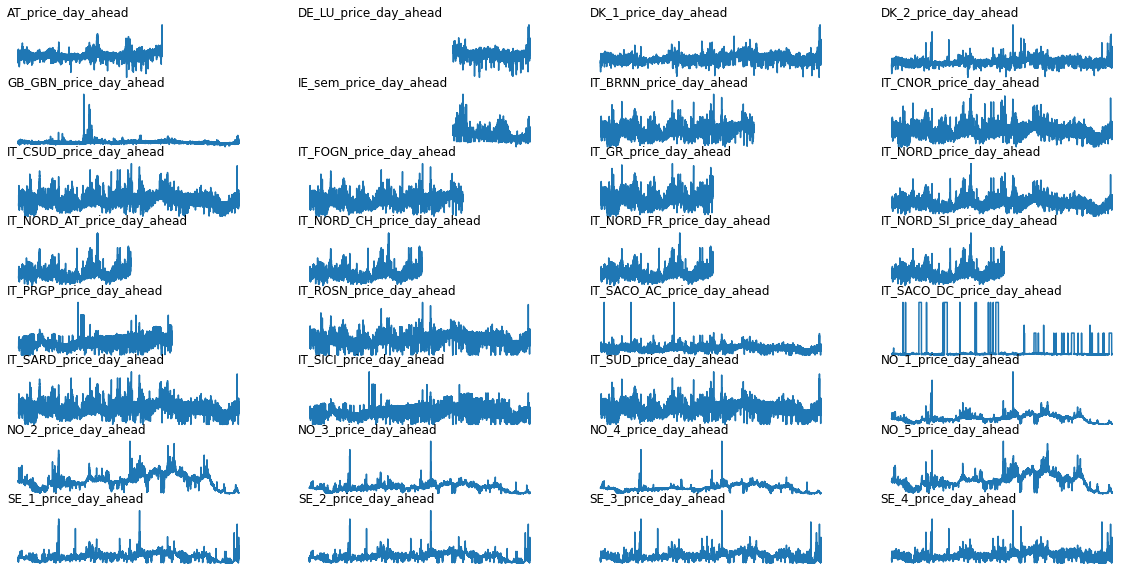

In [6]:
nrow, ncol = 8, 4

plt.subplots(nrows = nrow, ncols = ncol, figsize = (20,10), sharex = True, sharey = False)
for ii in range(y.shape[1]):
    
    plt.subplot(nrow, ncol, ii + 1)
    plt.plot(y.iloc[:, ii])
    
    plt.title(y.columns[ii], loc = 'left')
    plt.tick_params(axis='both', which='major', labelsize = 9)
    plt.axis('off')

Unfortunately not all targets are available for the entire time span the dataset covers. Also, the IT_SACO_DC series seems strange. Nevertheless, the data [here](https://transparency.entsoe.eu/transmission-domain/r2/dayAheadPrices/show?name=&defaultValue=true&viewType=GRAPH&areaType=BZN&atch=false&dateTime.dateTime=16.09.2020+00:00|UTC|DAY&biddingZone.values=CTY|10YIT-GRTN-----B!BZN|10Y1001A1001A699&resolution.values=PT15M&resolution.values=PT30M&resolution.values=PT60M&dateTime.timezone=UTC&dateTime.timezone_input=UTC) confirms the values appearing on the dataset.
In addition, to avoid generating separate datasets for each spot-price later on we will predict only the spot-prices that are available for the entire 5-year timeframe. These include:

In [7]:
targetDrop = ['AT', 'IT_NORD_AT', 'IT_PRGP', 'DE_LU', 'IE_sem', 'IT_FOGN', 'IT_SACO_DC', 
              'IT_NORD_CH', 'IT_BRNN', 'IT_GR', 'IT_NORD_FR', 'IT_NORD_SI']

targetDrop = [elem + '_price_day_ahead' for elem in targetDrop]

y.drop(targetDrop, axis = 1, inplace = True)

In [8]:
y.isnull().sum()

DK_1_price_day_ahead           15
DK_2_price_day_ahead           15
GB_GBN_price_day_ahead        111
IT_CNOR_price_day_ahead       134
IT_CSUD_price_day_ahead       134
IT_NORD_price_day_ahead       136
IT_ROSN_price_day_ahead       134
IT_SACO_AC_price_day_ahead    134
IT_SARD_price_day_ahead       134
IT_SICI_price_day_ahead       134
IT_SUD_price_day_ahead        134
NO_1_price_day_ahead           15
NO_2_price_day_ahead           15
NO_3_price_day_ahead           39
NO_4_price_day_ahead           15
NO_5_price_day_ahead           15
SE_1_price_day_ahead           15
SE_2_price_day_ahead           39
SE_3_price_day_ahead           15
SE_4_price_day_ahead           15
dtype: int64

Let's interpolate the few remaining missing values:

In [9]:
y.interpolate(method = 'time', inplace = True)
y.fillna(method = 'bfill', inplace = True)

### Distributions

Let's check the distributions of the targets:

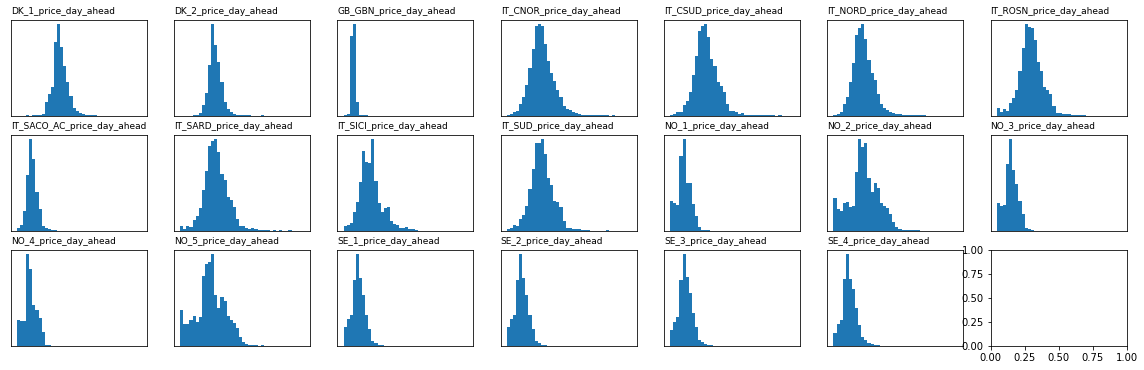

In [10]:
nrow, ncol = 3, 7

plt.subplots(nrows = nrow, ncols = ncol, figsize = (20, 6), sharex = False, sharey = False)
for ii in range(y.shape[1]):
    
    plt.subplot(nrow, ncol, ii + 1)
    plt.hist(y.iloc[:, ii], bins = 40)
    
    plt.title(y.columns[ii], loc = 'left', fontsize = 9)
    plt.tick_params(axis='both', which='major', labelsize = 9)
    plt.xticks([])
    plt.yticks([])

Approximately normal and some skewed. The problem though are the spikes shown in the previous graph, but these can be fixed by using the [inverse hyperbolic sinse variance stabilising transformation](https://ieeexplore.ieee.org/document/7997921).

## Predictors: Missing values

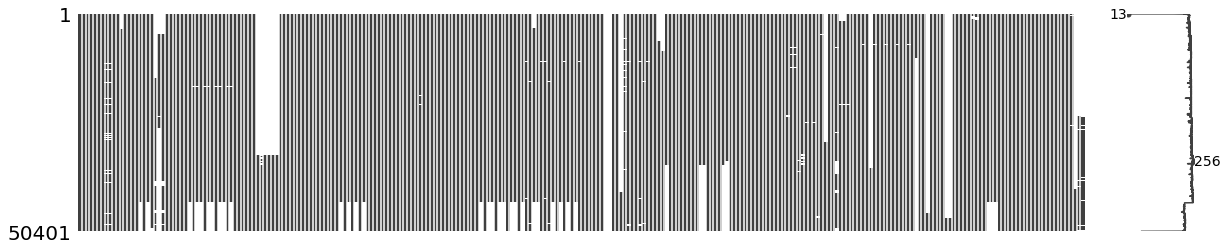

In [11]:
msno.matrix(X, figsize = (20, 4));

We have features with the majority of the data missing, we have a few features with a couple of values only missing, and few features with missing values at relatively big 'chunks', usually at the beginning and end of the dataset.

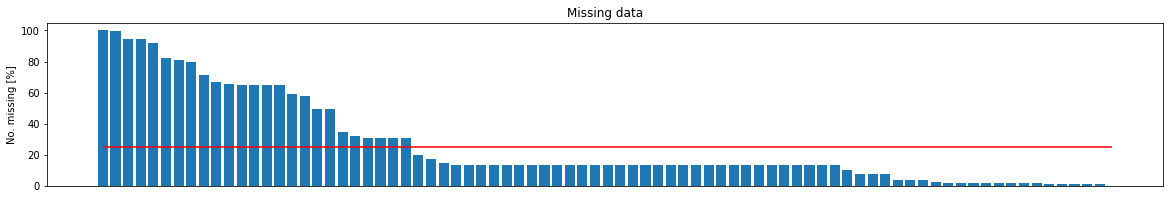

In [12]:
msng = X.isnull().sum(axis = 0).sort_values(ascending = False) / df.shape[0] * 100
msng = msng[msng > 1]

plt.figure(figsize = (20, 3))
plt.bar(msng.index, msng)
plt.hlines(25, xmin = 0, xmax = msng.shape[0], color = 'r')
plt.xticks([]);
plt.title('Missing data');
plt.ylabel('No. missing [%]');

Features with more than 25% missing values (approximately 1 year) will be dropped. The rest we'll impute

In [13]:
X.drop(msng.index.values[msng >= 25], axis = 1, inplace = True)
msng = msng[msng < 25]

Let's find the biggest continuous gap of data for the remaining features:

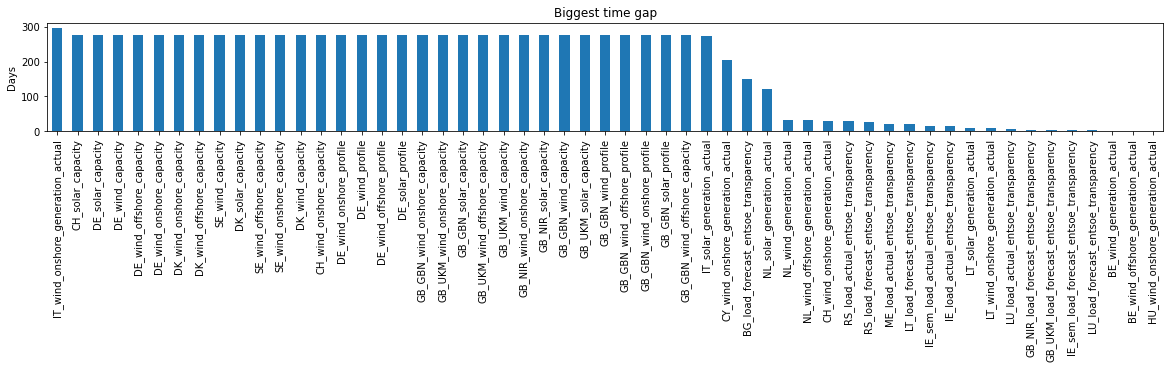

In [14]:
daysMissing = []
for feat in msng.index.values:
    col    = X[feat]
    maxGap = col.isnull().astype(int).groupby(col.notnull().astype(int).cumsum()).cumsum().to_frame('consec_count').max()
    daysMissing.append(maxGap[0] / 24) # Convert to days
    
msngDays = pd.Series(index = msng.index.values, data = daysMissing).sort_values(ascending = False)
msngDays.plot(kind = 'bar', figsize = (20, 2), title = 'Biggest time gap', ylabel = 'Days');

Now that the columns with the big chunks of time missing have been identified, they can be imputed. Capacities will be filled in by padding (both back- and forward-filling), whereas load generation will be filled by shifting one year forward or backwards.

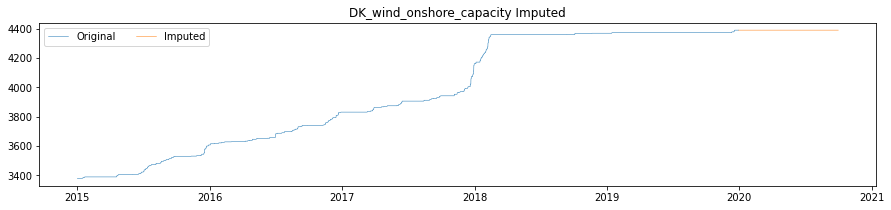

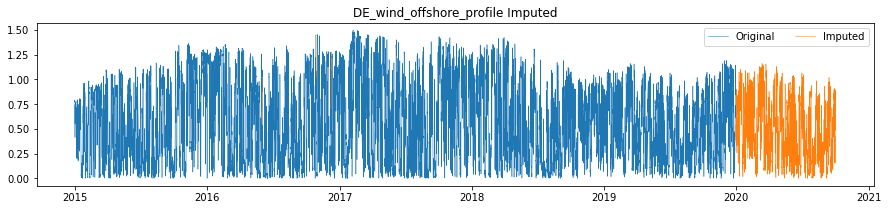

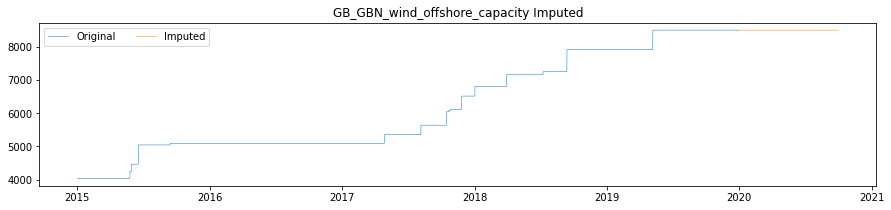

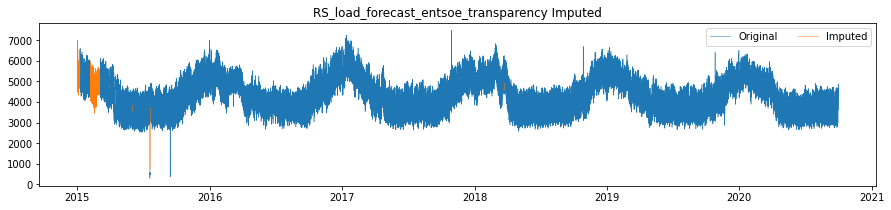

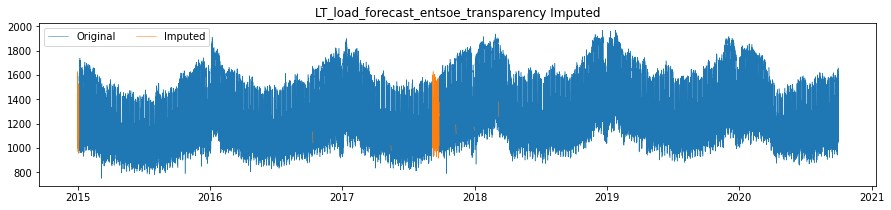

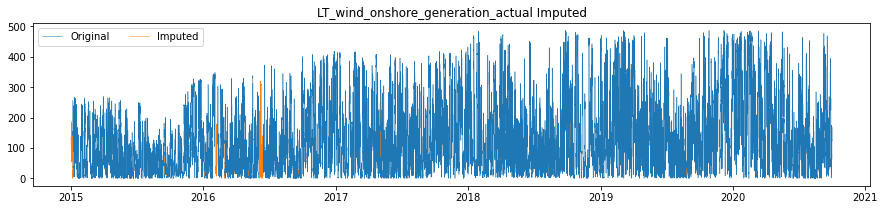

In [15]:
for colname in msngDays.index.values:

    oldCol     = X[colname].copy()
    imputedCol = imputeTS(oldCol)

    if np.random.rand() <= 0.1: # Plot some results
        plotImputation(oldCol, imputedCol, withMean = False)
        
    X[colname] = imputedCol

Following the imputation of the features missing more data, we can just interpolate the remaining ones, or backfill the few missing values in the beginning:

In [16]:
X.interpolate(method = 'time', inplace = True)
X.backfill(inplace = True)

## Predictors: Variable distributions

Check for highly skewed variables

In [17]:
sVars = X.skew(axis = 0).abs().sort_values(ascending = False).head(40)

sVars.head(5)

SK_load_actual_entsoe_transparency      223.027962
EE_solar_generation_actual               11.386496
CH_solar_generation_actual                4.931114
NL_solar_generation_actual                2.922274
LU_load_forecast_entsoe_transparency      2.338810
dtype: float64

Something is definitely wrong with the top variable:

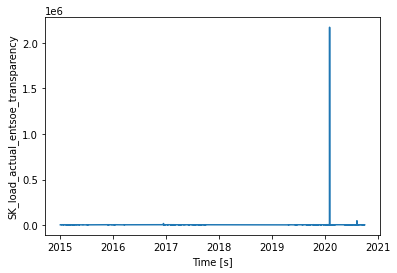

In [18]:
colname = 'SK_load_actual_entsoe_transparency'
plt.plot(X[colname]);
plt.ylabel('SK_load_actual_entsoe_transparency');
plt.xlabel('Time [s]');

Indeed

In [19]:
X[colname][X[colname] > 5e5] = np.nan
X.interpolate(method = 'time', inplace = True)

Let's have a look at the rest of them

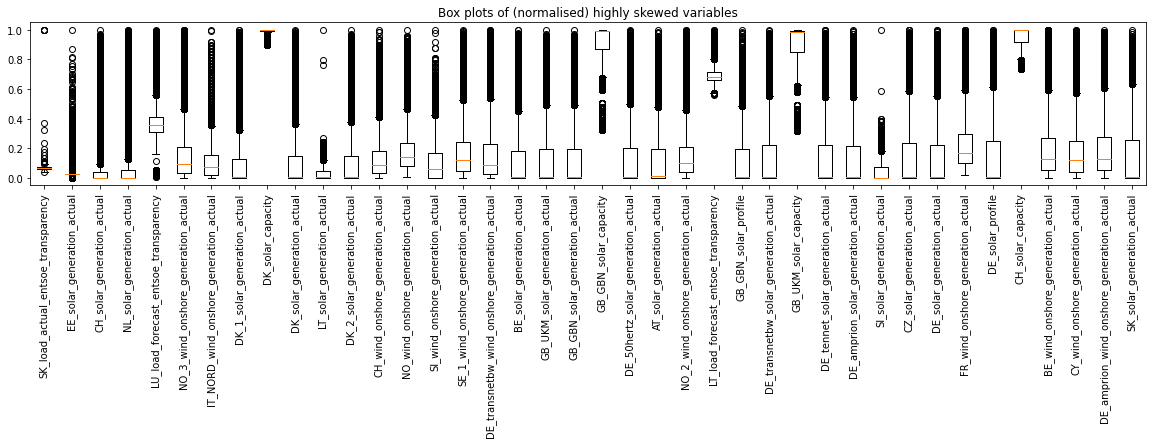

In [20]:
plt.figure(figsize = (20, 3))
plt.boxplot(X[sVars.index] / X[sVars.index].max(axis = 0));
plt.xticks(range(1, sVars.shape[0] + 1), sVars.index, rotation = 90);
plt.title('Box plots of (normalised) highly skewed variables');

This is a healthy mix of solar and onshore/offshore wind generation load.

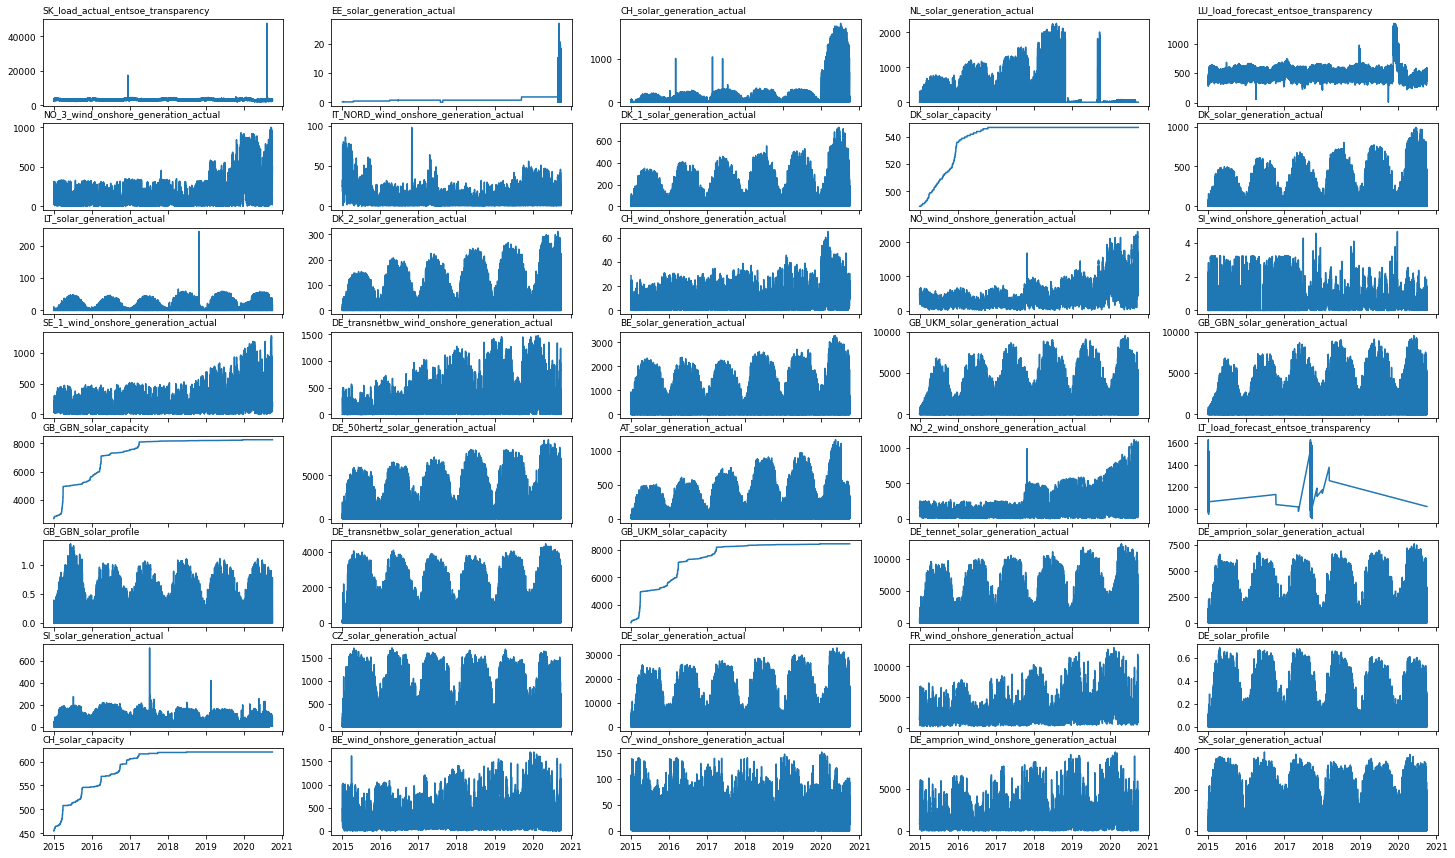

In [21]:
nrow, ncol = 8, 5

plt.subplots(nrows = nrow, ncols = ncol, figsize = (25,15), sharex = True, sharey = False)
for ii, col in enumerate(sVars.index):

    plt.subplot(nrow, ncol, ii + 1)
    plt.plot(X[col])
    
    plt.title(col, loc = 'left', fontsize = 9)
    plt.tick_params(axis='both', which='major', labelsize = 9)

Solar capacities are naturally skewed. No reason to do anything about that. The same applies to the rest of the variables. The inverse sinh transform will be applied to all of them as a pre-processing step except from the capacities time-series.

## Predictors: Constant

Check for any constant predictors:

In [22]:
constX = X.std(axis = 0).sort_values(ascending = True).head(10)
constX

SE_wind_offshore_capacity        0.000000
DK_wind_onshore_capacity         0.000000
GB_GBN_wind_offshore_capacity    0.000000
GB_GBN_wind_onshore_profile      0.150533
GB_GBN_wind_profile              0.154630
DE_solar_profile                 0.156260
GB_GBN_wind_offshore_profile     0.197597
DE_wind_onshore_profile          0.205720
DE_wind_profile                  0.209883
GB_GBN_solar_profile             0.241911
dtype: float64

Some constant capacities exist. We can remove those:

In [23]:
X.drop(constX.index[constX == 0], axis = 1, inplace = True)

## Highly correlated predictors

Check for highly correlated features (excl. capacities)

In [24]:
colsDrop  = X.columns[X.columns.str.contains('capacity')]
corr      = X.drop(colsDrop, axis = 1).corr(method = 'spearman').abs() # non-normal data
corrPairs = getCorrPairs(corr).reset_index()
corrPairs.head(20)

,level_0,level_1,0
0,GB_GBN_wind_offshore_generation_actual,GB_UKM_wind_offshore_generation_actual,1.000000
1,GB_GBN_solar_generation_actual,GB_UKM_solar_generation_actual,1.000000
2,SE_load_forecast_entsoe_transparency,SE_3_load_forecast_entsoe_transparency,0.998209
3,GB_GBN_wind_generation_actual,GB_UKM_wind_generation_actual,0.998120
4,GB_GBN_load_actual_entsoe_transparency,GB_UKM_load_actual_entsoe_transparency,0.998013
5,DK_load_actual_entsoe_transparency,DK_load_forecast_entsoe_transparency,0.996814
6,DK_solar_generation_actual,DK_1_solar_generation_actual,0.996805
7,GB_GBN_wind_onshore_generation_actual,GB_UKM_wind_onshore_generation_actual,0.996568
8,DK_1_load_actual_entsoe_transparency,DK_1_load_forecast_entsoe_transparency,0.996027
9,SE_load_actual_entsoe_transparency,SE_3_load_actual_entsoe_transparency,0.995968


In general: 
* ENTSOE 1-day ahead load forecasts are highly correlated with the actual loads, which means we can remove the actual loads and keep the one-day ahead forecasts.
* Actual & forecasted loads between different bidding zones of the same country are also highly correlated. The same applies to wind and solar generation.
* Wind generation and wind onshore generation are highly correlated for most countries.
* There seems to be small difference between solar generation and solar profile for most countries.
* Information regarding solar/wind/load capacities should be encoded in the corresponding profiles as well.

Based on the above, for each country we will retain:
* Load forecasts for each bidding zone
* Country-wide solar/wind generation or profile

In [25]:
# Define which columns to keep
colsKeep = [
"AT_load_forecast_entsoe_transparency",
"AT_solar_generation_actual",
"AT_wind_onshore_generation_actual",
"BE_load_forecast_entsoe_transparency",
"BE_solar_generation_actual",
"BE_wind_generation_actual",
"BG_load_forecast_entsoe_transparency",
"BG_solar_generation_actual",
"BG_wind_onshore_generation_actual",
"CH_load_forecast_entsoe_transparency",
"CY_wind_onshore_generation_actual",
"CZ_solar_generation_actual",
"CZ_wind_onshore_generation_actual",
"DE_solar_generation_actual",
"DE_wind_generation_actual",
"DE_50hertz_load_forecast_entsoe_transparency",
"DE_amprion_load_forecast_entsoe_transparency",
"DE_tennet_load_forecast_entsoe_transparency",
"DE_transnetbw_load_forecast_entsoe_transparency",
"DK_solar_generation_actual",
"DK_wind_generation_actual",
"DK_1_load_forecast_entsoe_transparency",
"DK_2_load_forecast_entsoe_transparency",
"EE_load_forecast_entsoe_transparency",
"EE_solar_generation_actual",
"EE_wind_onshore_generation_actual",
"ES_load_forecast_entsoe_transparency",
"ES_solar_generation_actual",
"ES_wind_onshore_generation_actual",
"FI_load_forecast_entsoe_transparency",
"FI_wind_onshore_generation_actual",
"FR_load_forecast_entsoe_transparency",
"FR_solar_generation_actual",
"FR_wind_onshore_generation_actual",
"GR_load_forecast_entsoe_transparency",
"GR_solar_generation_actual",
"GR_wind_onshore_generation_actual",
"HR_load_forecast_entsoe_transparency",
"HU_load_forecast_entsoe_transparency",
"HU_wind_onshore_generation_actual",
"IE_load_forecast_entsoe_transparency",
"IE_wind_onshore_generation_actual",
"IT_solar_generation_actual",
"IT_wind_onshore_generation_actual",
"IT_CNOR_load_forecast_entsoe_transparency",
"IT_CSUD_load_forecast_entsoe_transparency",
"IT_NORD_load_forecast_entsoe_transparency",
"IT_SARD_load_forecast_entsoe_transparency",
"IT_SICI_load_forecast_entsoe_transparency",
"IT_SUD_load_forecast_entsoe_transparency",
"LT_load_forecast_entsoe_transparency",
"LT_solar_generation_actual",
"LT_wind_onshore_generation_actual",
"LU_load_forecast_entsoe_transparency",
"LV_load_forecast_entsoe_transparency",
"LV_wind_onshore_generation_actual",
"ME_load_forecast_entsoe_transparency",
"NL_load_forecast_entsoe_transparency",
"NL_solar_generation_actual",
"NL_wind_generation_actual",
"NO_wind_onshore_generation_actual",
"NO_1_load_forecast_entsoe_transparency",
"NO_2_load_forecast_entsoe_transparency",
"NO_3_load_forecast_entsoe_transparency",
"NO_4_load_forecast_entsoe_transparency",
"NO_5_load_forecast_entsoe_transparency",
"PL_load_forecast_entsoe_transparency",
"PL_wind_onshore_generation_actual",
"PT_load_forecast_entsoe_transparency",
"PT_solar_generation_actual",
"PT_wind_onshore_generation_actual",
"RO_load_forecast_entsoe_transparency",
"RO_solar_generation_actual",
"RO_wind_onshore_generation_actual",
"RS_load_forecast_entsoe_transparency",
"SE_wind_onshore_generation_actual",
"SE_1_load_forecast_entsoe_transparency",
"SE_2_load_forecast_entsoe_transparency",
"SE_3_load_forecast_entsoe_transparency",
"SE_4_load_forecast_entsoe_transparency",
"SI_load_forecast_entsoe_transparency",
"SI_solar_generation_actual",
"SI_wind_onshore_generation_actual",
"SK_load_forecast_entsoe_transparency",
"SK_solar_generation_actual"]

X = X[colsKeep]

Save files:

In [26]:
X.to_csv('X.csv')
y.to_csv('y.csv')

## 